<a href="https://colab.research.google.com/github/VishwathRam/Sarcastic-comment-detection-in-Reddit/blob/main/Reddit_comment_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.layers import Conv1D, Flatten,MaxPooling1D
from keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sarcasm_df = 
    pd.read_csv('/content/drive/MyDrive/college/train-balanced-sarcasm.csv')
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
# Data Pre-Processing
# Removing the null comments
#Converting all the comments to lower-case
#Removing \s and \w from comments which are put by users to show if a comment is sarcastic or not
sarcasm_df.dropna(subset=['comment'], inplace=True)
sarcasm_df['comment'] = sarcasm_df['comment'].str.lower()
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
# Converting the timestamp into DateTime object
sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
sarcasm_df.info()
sarcasm_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010773 non-null  int64         
 1   comment         1010773 non-null  object        
 2   author          1010773 non-null  object        
 3   subreddit       1010773 non-null  object        
 4   score           1010773 non-null  int64         
 5   ups             1010773 non-null  int64         
 6   downs           1010773 non-null  int64         
 7   date            1010773 non-null  object        
 8   created_utc     1010773 non-null  datetime64[ns]
 9   parent_comment  1010773 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,they were underdogs earlier today but since gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,this meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,i could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


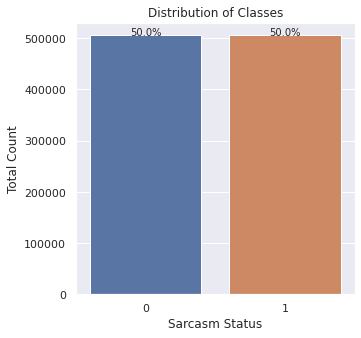

In [ ]:
#Making a plot of sarcastic and non-sarcastic comments
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= sarcasm_df)
ax.set(title = "Distribution of Classes", 
       xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center") 
plt.show()

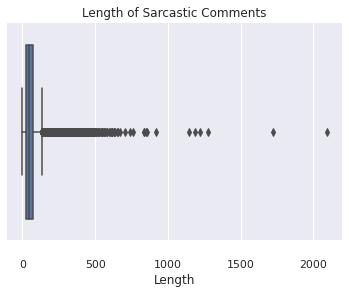

In [ ]:
# Distribution of the length of Sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 1,
    'comment'].str.len()).set(title='Sarcastic Comments Length',xlabel='Length')
sns.despine(offset=10, trim=True)
plt.show()

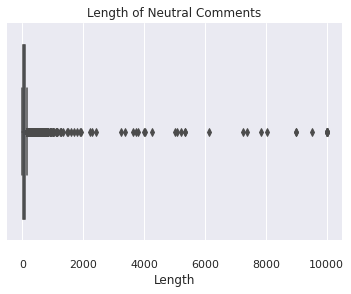

In [ ]:
# Distribution of the lenth of Neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 0, 
      'comment'].str.len()).set(title='Neutral Comments Length',xlabel='Length')
sns.despine(offset=10, trim=True)
plt.show()

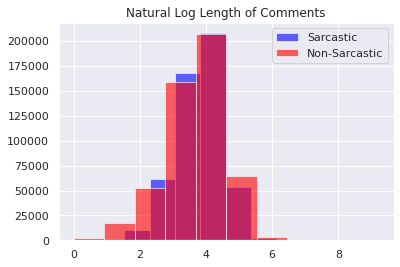

In [ ]:
#Plot of natural log of length of comments 
sarcasm_df['log_comment'] = 
      sarcasm_df['comment'].apply(lambda text:np.log1p(len(text)))
sarcasm_df[sarcasm_df['label']==1]['log_comment']
      .hist(alpha=0.6,label='Sarcastic', color = 'blue')
sarcasm_df[sarcasm_df['label']==0]['log_comment']
      .hist(alpha=0.6,label='Non-Sarcastic', color = 'red')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

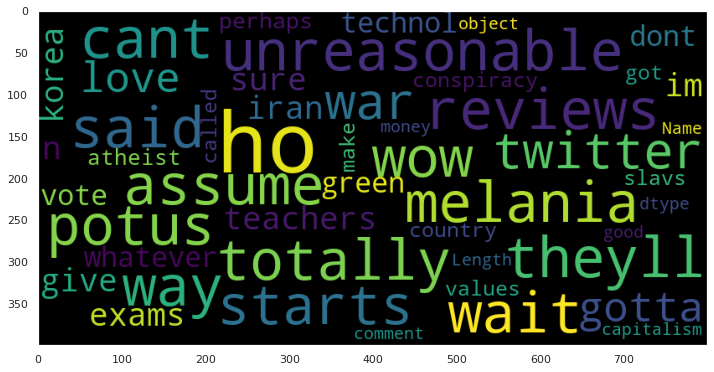

In [ ]:
#Wordcloud of most popular words in comments
wordcloud = WordCloud(background_color='black', 
                stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(
    sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

In [ ]:
# Converting the scores into numpy array
sarcasm_score = np.array(sarcasm_df
          .loc[sarcasm_df['label'] == 1]['score'])
neutral_score = np.array(sarcasm_df
          .loc[sarcasm_df['label'] == 0]['score'])

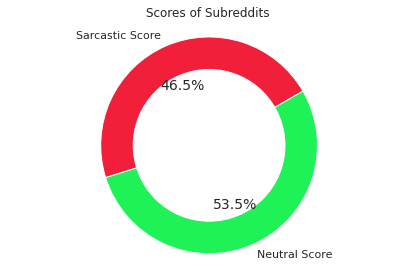

In [ ]:
# Displaying the distribution of Marital Status in a Pie chart
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']
 
plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, 
        autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.tight_layout()
plt.show()

In [ ]:
#length of sarcastic comment compared to parent comment
sarcasm_comm_len = np.array(sarcasm_df
    .loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df
    .loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df
    .loc[sarcasm_df['label'] == 1]['comment'].str.len())/
    (sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))

In [ ]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 
                        'Parent Comment Length': parent_comm_len, 
                        'Ratio Length': ratio_len}, 
                       columns=['Comment Length', 
                                'Parent Comment Length', 
                                'Ratio Length'])

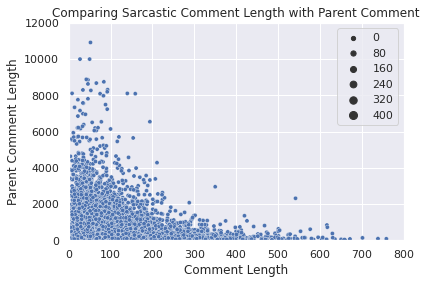

In [ ]:
ax = plt.axes()
sns.scatterplot(data=dataset, 
                x="Comment Length", 
                y="Parent Comment Length",  
                size=ratio_len)
ax.set_title("Comparing Sarcastic Comment with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

In [ ]:
# Getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

AskReddit          65674
politics           39493
worldnews          26376
leagueoflegends    21034
pcmasterrace       18987
Name: subreddit, dtype: int64

In [ ]:
# Feature Engineering- Extracting the day of a week
sarcasm_df['created_utc'] = 
    pd.to_datetime(sarcasm_df['created_utc'],format='%d/%m/%Y %H:%M:%S')
sarcasm_df['Day of Week'] = 
    sarcasm_df['created_utc'].dt.day_name()

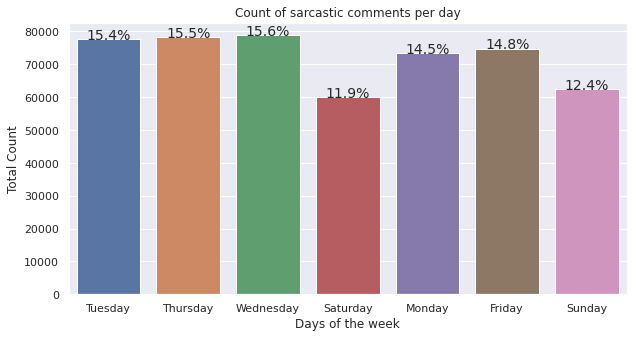

In [ ]:
# Visualization of Column- label
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  
                   data=sarcasm_df.loc[sarcasm_df['label']==1])
ax.set(title = "Count of sarcastic comments per day", 
       xlabel="Days of the week", ylabel = "Total Count")
total = float(len(sarcasm_df ))
train_ac_lstm=0.68
test_ac_lstm=0.68
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

In [ ]:
logit = LogisticRegression(random_state= 42)

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(sarcasm_df['comment'])
x_train, x_test, y_train, y_test = 
    train_test_split(X_tf_idf, sarcasm_df['label'], random_state=42)



logit.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [ ]:
predicted_class=logit.predict(x_test)
predicted_class_train=logit.predict(x_train)
test_probs = logit.predict_proba(x_test)
test_probs = test_probs[:, 1]
yhat = logit.predict(x_test)
train_accuracy = accuracy_score(y_train,predicted_class_train)
test_accuracy = accuracy_score(y_test,predicted_class)
print("Train accuracy score: ", train_accuracy)
print("Test accuracy score: ",test_accuracy )
print()

Train accuracy score:  0.7224669196745985
Test accuracy score:  0.6934988563242499



In [ ]:

sarcasm_df.reset_index(drop = True, inplace = True)
corpus=[sarcasm_df['comment'][i] for i in range(len(sarcasm_df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length = 20

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=40

X_final=np.array(embedded_docs)
y_final=np.array(sarcasm_df['label'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = 
      train_test_split(X_final,y_final,test_size=0.33,random_state=42)

In [ ]:
lstm_model=Sequential()
lstm_model.add(Embedding(voc_size,embedding_vector_features,
                         input_length=max_sent_length))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Flatten())
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',metrics=['accuracy'])

In [ ]:
lstm_model.fit(X_train_lstm,y_train_lstm,validation_data=
          (X_test_lstm,y_test_lstm),epochs=10,batch_size=64)

Epoch 1/10
10582/10582 [==============================] - 127s 11ms/step - loss: 0.5914 - accuracy: 0.6802 - val_loss: 0.5717 - val_accuracy: 0.6983
Epoch 2/10
10582/10582 [==============================] - 117s 11ms/step - loss: 0.5671 - accuracy: 0.7012 - val_loss: 0.5658 - val_accuracy: 0.7019
Epoch 3/10
10582/10582 [==============================] - 118s 11ms/step - loss: 0.5572 - accuracy: 0.7092 - val_loss: 0.5632 - val_accuracy: 0.7034
Epoch 4/10
10582/10582 [==============================] - 117s 11ms/step - loss: 0.5499 - accuracy: 0.7148 - val_loss: 0.5619 - val_accuracy: 0.7053
Epoch 5/10
10582/10582 [==============================] - 117s 11ms/step - loss: 0.5430 - accuracy: 0.7202 - val_loss: 0.5613 - val_accuracy: 0.7063
Epoch 6/10
10582/10582 [==============================] - 120s 11ms/step - loss: 0.5368 - accuracy: 0.7248 - val_loss: 0.5614 - val_accuracy: 0.7075
Epoch 7/10
10582/10582 [==============================] - 116s 11ms/step - loss: 0.5323 - accuracy: 0.7284

In [ ]:
predict_x=lstm_model.predict(X_test_lstm)
y_test_pred=np.argmax(predict_x,axis=1)

predict_y=lstm_model.predict(X_train_lstm)
y_train_pred=np.argmax(predict_y,axis=1)

test_acc_lstm = accuracy_score(y_test_lstm,y_test_pred)
train_acc_lstm = accuracy_score(y_train_lstm,y_train_pred)


print('Train accuracy of lstm: ',train_ac_lstm)

print('Test accuracy of lstm: ', test_ac_lstm)

21164/21164 [==============================] - 58s 3ms/step
Train accuracy of lstm:  0.5004496343121924
Test accuracy of lstm:  0.4991425727613954


In [ ]:
vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df['comment'],
                sarcasm_df['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

AttributeError: ignored

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Dropout(.5))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='relu'))
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


cnn_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1,batch_size=64)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
max_words=5000
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,
            save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),
            callbacks=[checkpoint2])

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
svc = LinearSVC()
svc.fit(X_train_csv, y_train_csv)
#y_pred = svc.predict(x_train)
predicted_class = svc.predict(X_test_csv)
print(accuracy_score(y_test_csv,predicted_class))
